In [15]:
import warnings
warnings.filterwarnings('ignore')

import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

from IPython.display import HTML as html_print

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

In [16]:
%%time
train = pd.read_pickle("data\\train_data")


Wall time: 14.8 s


In [17]:
train.columns

Index(['acoustic_data', 'time_to_failure'], dtype='object')

In [18]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


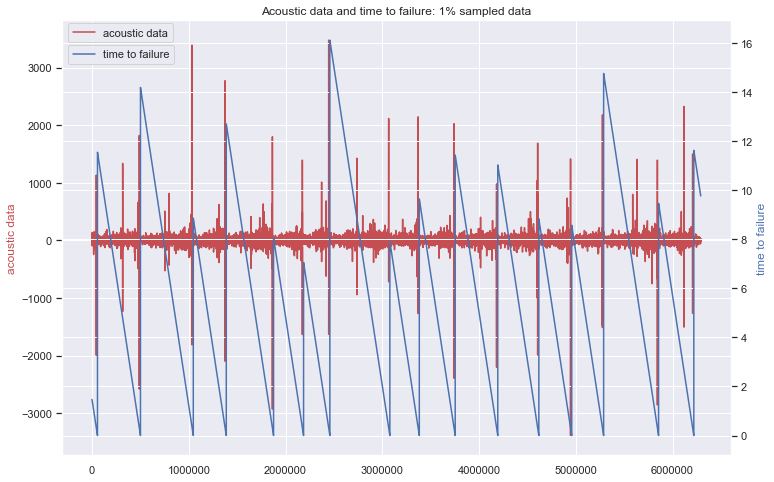

In [19]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [20]:


    
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    z = np.fft.fft(x)
    #FFT transform values
    realFFT = np.real(z)
    imagFFT = np.imag(z)
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X_train.loc[segment, 'Rstd__last_15000'] = realFFT[-15000:].std()
    X_train.loc[segment, 'Imean'] = imagFFT.mean()
    for windows in [10,100,300,600,1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_train.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_train.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_train.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_train.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_train.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()      
        X_train.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_train.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_train.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_train.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_train.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_train.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_train.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    





  0%|          | 0/4194 [00:00<?, ?it/s]


  0%|          | 1/4194 [00:01<1:23:35,  1.20s/it]


  0%|          | 2/4194 [00:01<1:09:33,  1.00it/s]


  0%|          | 3/4194 [00:02<59:23,  1.18it/s]  


  0%|          | 4/4194 [00:02<52:51,  1.32it/s]


  0%|          | 5/4194 [00:03<48:31,  1.44it/s]


  0%|          | 6/4194 [00:03<45:45,  1.53it/s]


  0%|          | 7/4194 [00:04<43:19,  1.61it/s]


  0%|          | 8/4194 [00:04<41:52,  1.67it/s]


  0%|          | 9/4194 [00:05<40:04,  1.74it/s]


  0%|          | 10/4194 [00:06<38:37,  1.81it/s]


  0%|          | 11/4194 [00:06<38:30,  1.81it/s]


  0%|          | 12/4194 [00:07<38:04,  1.83it/s]


  0%|          | 13/4194 [00:07<37:48,  1.84it/s]


  0%|          | 14/4194 [00:08<37:10,  1.87it/s]


  0%|          | 15/4194 [00:08<36:59,  1.88it/s]


  0%|          | 16/4194 [00:09<37:13,  1.87it/s]


  0%|          | 17/4194 [00:09<37:01,  1.88it/s]


  0%|          | 18/4194 [00:10<37:05,  1.88it/s]


  0%|          | 19/4

  7%|▋         | 310/4194 [02:44<35:37,  1.82it/s]


  7%|▋         | 311/4194 [02:44<35:04,  1.85it/s]


  7%|▋         | 312/4194 [02:45<34:24,  1.88it/s]


  7%|▋         | 313/4194 [02:46<35:24,  1.83it/s]


  7%|▋         | 314/4194 [02:46<34:16,  1.89it/s]


  8%|▊         | 315/4194 [02:47<33:31,  1.93it/s]


  8%|▊         | 316/4194 [02:47<33:28,  1.93it/s]


  8%|▊         | 317/4194 [02:48<33:09,  1.95it/s]


  8%|▊         | 318/4194 [02:48<33:31,  1.93it/s]


  8%|▊         | 319/4194 [02:49<33:44,  1.91it/s]


  8%|▊         | 320/4194 [02:49<33:27,  1.93it/s]


  8%|▊         | 321/4194 [02:50<32:27,  1.99it/s]


  8%|▊         | 322/4194 [02:50<32:07,  2.01it/s]


  8%|▊         | 323/4194 [02:51<32:01,  2.01it/s]


  8%|▊         | 324/4194 [02:51<31:17,  2.06it/s]


  8%|▊         | 325/4194 [02:51<30:44,  2.10it/s]


  8%|▊         | 326/4194 [02:52<31:36,  2.04it/s]


  8%|▊         | 327/4194 [02:52<31:20,  2.06it/s]


  8%|▊         | 328/4194 [02:53<33:03,  1.95i

 15%|█▍        | 618/4194 [05:25<29:18,  2.03it/s]


 15%|█▍        | 619/4194 [05:26<29:38,  2.01it/s]


 15%|█▍        | 620/4194 [05:26<29:30,  2.02it/s]


 15%|█▍        | 621/4194 [05:26<29:26,  2.02it/s]


 15%|█▍        | 622/4194 [05:27<29:25,  2.02it/s]


 15%|█▍        | 623/4194 [05:27<28:42,  2.07it/s]


 15%|█▍        | 624/4194 [05:28<28:47,  2.07it/s]


 15%|█▍        | 625/4194 [05:28<28:48,  2.06it/s]


 15%|█▍        | 626/4194 [05:29<29:20,  2.03it/s]


 15%|█▍        | 627/4194 [05:29<29:48,  1.99it/s]


 15%|█▍        | 628/4194 [05:30<30:09,  1.97it/s]


 15%|█▍        | 629/4194 [05:30<29:36,  2.01it/s]


 15%|█▌        | 630/4194 [05:31<29:35,  2.01it/s]


 15%|█▌        | 631/4194 [05:31<30:27,  1.95it/s]


 15%|█▌        | 632/4194 [05:32<31:09,  1.91it/s]


 15%|█▌        | 633/4194 [05:33<31:27,  1.89it/s]


 15%|█▌        | 634/4194 [05:33<32:41,  1.82it/s]


 15%|█▌        | 635/4194 [05:34<33:43,  1.76it/s]


 15%|█▌        | 636/4194 [05:34<32:54,  1.80i

 22%|██▏       | 926/4194 [08:07<31:47,  1.71it/s]


 22%|██▏       | 927/4194 [08:07<30:57,  1.76it/s]


 22%|██▏       | 928/4194 [08:08<30:52,  1.76it/s]


 22%|██▏       | 929/4194 [08:08<31:40,  1.72it/s]


 22%|██▏       | 930/4194 [08:09<32:02,  1.70it/s]


 22%|██▏       | 931/4194 [08:10<33:21,  1.63it/s]


 22%|██▏       | 932/4194 [08:10<31:29,  1.73it/s]


 22%|██▏       | 933/4194 [08:11<30:41,  1.77it/s]


 22%|██▏       | 934/4194 [08:11<30:37,  1.77it/s]


 22%|██▏       | 935/4194 [08:12<29:34,  1.84it/s]


 22%|██▏       | 936/4194 [08:12<30:47,  1.76it/s]


 22%|██▏       | 937/4194 [08:13<34:12,  1.59it/s]


 22%|██▏       | 938/4194 [08:14<35:38,  1.52it/s]


 22%|██▏       | 939/4194 [08:14<34:58,  1.55it/s]


 22%|██▏       | 940/4194 [08:15<33:04,  1.64it/s]


 22%|██▏       | 941/4194 [08:16<32:37,  1.66it/s]


 22%|██▏       | 942/4194 [08:16<33:06,  1.64it/s]


 22%|██▏       | 943/4194 [08:17<34:36,  1.57it/s]


 23%|██▎       | 944/4194 [08:17<33:19,  1.63i

 29%|██▉       | 1230/4194 [10:48<30:35,  1.61it/s]


 29%|██▉       | 1231/4194 [10:49<30:51,  1.60it/s]


 29%|██▉       | 1232/4194 [10:49<29:07,  1.69it/s]


 29%|██▉       | 1233/4194 [10:50<28:01,  1.76it/s]


 29%|██▉       | 1234/4194 [10:50<27:35,  1.79it/s]


 29%|██▉       | 1235/4194 [10:51<25:23,  1.94it/s]


 29%|██▉       | 1236/4194 [10:51<23:54,  2.06it/s]


 29%|██▉       | 1237/4194 [10:52<24:16,  2.03it/s]


 30%|██▉       | 1238/4194 [10:52<24:34,  2.01it/s]


 30%|██▉       | 1239/4194 [10:53<24:45,  1.99it/s]


 30%|██▉       | 1240/4194 [10:53<25:40,  1.92it/s]


 30%|██▉       | 1241/4194 [10:54<29:11,  1.69it/s]


 30%|██▉       | 1242/4194 [10:55<28:17,  1.74it/s]


 30%|██▉       | 1243/4194 [10:55<26:30,  1.86it/s]


 30%|██▉       | 1244/4194 [10:56<26:15,  1.87it/s]


 30%|██▉       | 1245/4194 [10:56<25:32,  1.92it/s]


 30%|██▉       | 1246/4194 [10:56<24:56,  1.97it/s]


 30%|██▉       | 1247/4194 [10:57<25:31,  1.92it/s]


 30%|██▉       | 1248/4194 [

 37%|███▋      | 1532/4194 [13:30<24:15,  1.83it/s]


 37%|███▋      | 1533/4194 [13:31<24:15,  1.83it/s]


 37%|███▋      | 1534/4194 [13:32<25:09,  1.76it/s]


 37%|███▋      | 1535/4194 [13:32<24:55,  1.78it/s]


 37%|███▋      | 1536/4194 [13:33<25:05,  1.77it/s]


 37%|███▋      | 1537/4194 [13:33<25:36,  1.73it/s]


 37%|███▋      | 1538/4194 [13:34<25:42,  1.72it/s]


 37%|███▋      | 1539/4194 [13:34<24:58,  1.77it/s]


 37%|███▋      | 1540/4194 [13:35<24:39,  1.79it/s]


 37%|███▋      | 1541/4194 [13:36<24:19,  1.82it/s]


 37%|███▋      | 1542/4194 [13:36<24:17,  1.82it/s]


 37%|███▋      | 1543/4194 [13:37<24:15,  1.82it/s]


 37%|███▋      | 1544/4194 [13:37<24:12,  1.82it/s]


 37%|███▋      | 1545/4194 [13:38<24:07,  1.83it/s]


 37%|███▋      | 1546/4194 [13:38<24:23,  1.81it/s]


 37%|███▋      | 1547/4194 [13:39<24:01,  1.84it/s]


 37%|███▋      | 1548/4194 [13:39<24:10,  1.82it/s]


 37%|███▋      | 1549/4194 [13:40<23:57,  1.84it/s]


 37%|███▋      | 1550/4194 [

 44%|████▎     | 1834/4194 [16:08<21:35,  1.82it/s]


 44%|████▍     | 1835/4194 [16:08<21:31,  1.83it/s]


 44%|████▍     | 1836/4194 [16:09<21:54,  1.79it/s]


 44%|████▍     | 1837/4194 [16:10<21:39,  1.81it/s]


 44%|████▍     | 1838/4194 [16:10<21:29,  1.83it/s]


 44%|████▍     | 1839/4194 [16:11<20:52,  1.88it/s]


 44%|████▍     | 1840/4194 [16:11<20:10,  1.94it/s]


 44%|████▍     | 1841/4194 [16:12<20:45,  1.89it/s]


 44%|████▍     | 1842/4194 [16:12<21:04,  1.86it/s]


 44%|████▍     | 1843/4194 [16:13<21:40,  1.81it/s]


 44%|████▍     | 1844/4194 [16:13<22:33,  1.74it/s]


 44%|████▍     | 1845/4194 [16:14<22:29,  1.74it/s]


 44%|████▍     | 1846/4194 [16:15<22:04,  1.77it/s]


 44%|████▍     | 1847/4194 [16:15<21:59,  1.78it/s]


 44%|████▍     | 1848/4194 [16:16<21:24,  1.83it/s]


 44%|████▍     | 1849/4194 [16:16<21:20,  1.83it/s]


 44%|████▍     | 1850/4194 [16:17<21:12,  1.84it/s]


 44%|████▍     | 1851/4194 [16:17<21:09,  1.85it/s]


 44%|████▍     | 1852/4194 [

 51%|█████     | 2136/4194 [18:52<18:29,  1.86it/s]


 51%|█████     | 2137/4194 [18:52<18:36,  1.84it/s]


 51%|█████     | 2138/4194 [18:53<18:36,  1.84it/s]


 51%|█████     | 2139/4194 [18:53<19:13,  1.78it/s]


 51%|█████     | 2140/4194 [18:54<20:42,  1.65it/s]


 51%|█████     | 2141/4194 [18:54<20:28,  1.67it/s]


 51%|█████     | 2142/4194 [18:55<20:04,  1.70it/s]


 51%|█████     | 2143/4194 [18:56<19:39,  1.74it/s]


 51%|█████     | 2144/4194 [18:56<19:24,  1.76it/s]


 51%|█████     | 2145/4194 [18:57<18:59,  1.80it/s]


 51%|█████     | 2146/4194 [18:57<18:44,  1.82it/s]


 51%|█████     | 2147/4194 [18:58<18:21,  1.86it/s]


 51%|█████     | 2148/4194 [18:58<18:04,  1.89it/s]


 51%|█████     | 2149/4194 [18:59<18:01,  1.89it/s]


 51%|█████▏    | 2150/4194 [18:59<17:50,  1.91it/s]


 51%|█████▏    | 2151/4194 [19:00<18:03,  1.89it/s]


 51%|█████▏    | 2152/4194 [19:00<18:00,  1.89it/s]


 51%|█████▏    | 2153/4194 [19:01<18:29,  1.84it/s]


 51%|█████▏    | 2154/4194 [

 58%|█████▊    | 2438/4194 [21:34<16:21,  1.79it/s]


 58%|█████▊    | 2439/4194 [21:34<15:58,  1.83it/s]


 58%|█████▊    | 2440/4194 [21:35<14:51,  1.97it/s]


 58%|█████▊    | 2441/4194 [21:35<15:23,  1.90it/s]


 58%|█████▊    | 2442/4194 [21:36<17:21,  1.68it/s]


 58%|█████▊    | 2443/4194 [21:37<16:32,  1.76it/s]


 58%|█████▊    | 2444/4194 [21:37<16:38,  1.75it/s]


 58%|█████▊    | 2445/4194 [21:38<15:55,  1.83it/s]


 58%|█████▊    | 2446/4194 [21:38<13:35,  2.14it/s]


 58%|█████▊    | 2447/4194 [21:38<12:05,  2.41it/s]


 58%|█████▊    | 2448/4194 [21:39<11:50,  2.46it/s]


 58%|█████▊    | 2449/4194 [21:39<12:48,  2.27it/s]


 58%|█████▊    | 2450/4194 [21:40<14:41,  1.98it/s]


 58%|█████▊    | 2451/4194 [21:40<15:14,  1.91it/s]


 58%|█████▊    | 2452/4194 [21:41<15:11,  1.91it/s]


 58%|█████▊    | 2453/4194 [21:41<15:44,  1.84it/s]


 59%|█████▊    | 2454/4194 [21:42<16:12,  1.79it/s]


 59%|█████▊    | 2455/4194 [21:43<16:13,  1.79it/s]


 59%|█████▊    | 2456/4194 [

 65%|██████▌   | 2740/4194 [24:06<15:12,  1.59it/s]


 65%|██████▌   | 2741/4194 [24:07<15:22,  1.57it/s]


 65%|██████▌   | 2742/4194 [24:07<14:31,  1.67it/s]


 65%|██████▌   | 2743/4194 [24:08<14:27,  1.67it/s]


 65%|██████▌   | 2744/4194 [24:09<14:17,  1.69it/s]


 65%|██████▌   | 2745/4194 [24:09<14:29,  1.67it/s]


 65%|██████▌   | 2746/4194 [24:10<14:33,  1.66it/s]


 65%|██████▌   | 2747/4194 [24:10<13:33,  1.78it/s]


 66%|██████▌   | 2748/4194 [24:11<13:16,  1.82it/s]


 66%|██████▌   | 2749/4194 [24:11<13:16,  1.82it/s]


 66%|██████▌   | 2750/4194 [24:12<13:09,  1.83it/s]


 66%|██████▌   | 2751/4194 [24:12<12:40,  1.90it/s]


 66%|██████▌   | 2752/4194 [24:13<14:02,  1.71it/s]


 66%|██████▌   | 2753/4194 [24:14<14:08,  1.70it/s]


 66%|██████▌   | 2754/4194 [24:14<12:03,  1.99it/s]


 66%|██████▌   | 2755/4194 [24:14<10:45,  2.23it/s]


 66%|██████▌   | 2756/4194 [24:15<11:31,  2.08it/s]


 66%|██████▌   | 2757/4194 [24:15<11:32,  2.07it/s]


 66%|██████▌   | 2758/4194 [

 73%|███████▎  | 3042/4194 [26:50<10:26,  1.84it/s]


 73%|███████▎  | 3043/4194 [26:50<10:20,  1.85it/s]


 73%|███████▎  | 3044/4194 [26:51<10:09,  1.89it/s]


 73%|███████▎  | 3045/4194 [26:51<09:41,  1.98it/s]


 73%|███████▎  | 3046/4194 [26:52<10:01,  1.91it/s]


 73%|███████▎  | 3047/4194 [26:52<10:02,  1.90it/s]


 73%|███████▎  | 3048/4194 [26:53<10:13,  1.87it/s]


 73%|███████▎  | 3049/4194 [26:53<10:30,  1.82it/s]


 73%|███████▎  | 3050/4194 [26:54<10:48,  1.76it/s]


 73%|███████▎  | 3051/4194 [26:54<10:39,  1.79it/s]


 73%|███████▎  | 3052/4194 [26:55<09:43,  1.96it/s]


 73%|███████▎  | 3053/4194 [26:55<09:34,  1.99it/s]


 73%|███████▎  | 3054/4194 [26:56<09:09,  2.08it/s]


 73%|███████▎  | 3055/4194 [26:56<09:30,  2.00it/s]


 73%|███████▎  | 3056/4194 [26:57<09:36,  1.97it/s]


 73%|███████▎  | 3057/4194 [26:57<09:03,  2.09it/s]


 73%|███████▎  | 3058/4194 [26:58<09:09,  2.07it/s]


 73%|███████▎  | 3059/4194 [26:58<09:19,  2.03it/s]


 73%|███████▎  | 3060/4194 [

 80%|███████▉  | 3344/4194 [29:34<07:48,  1.82it/s]


 80%|███████▉  | 3345/4194 [29:35<07:49,  1.81it/s]


 80%|███████▉  | 3346/4194 [29:35<07:42,  1.83it/s]


 80%|███████▉  | 3347/4194 [29:36<07:40,  1.84it/s]


 80%|███████▉  | 3348/4194 [29:36<07:40,  1.84it/s]


 80%|███████▉  | 3349/4194 [29:37<07:35,  1.85it/s]


 80%|███████▉  | 3350/4194 [29:37<07:31,  1.87it/s]


 80%|███████▉  | 3351/4194 [29:38<07:32,  1.86it/s]


 80%|███████▉  | 3352/4194 [29:38<07:34,  1.85it/s]


 80%|███████▉  | 3353/4194 [29:39<07:39,  1.83it/s]


 80%|███████▉  | 3354/4194 [29:39<07:38,  1.83it/s]


 80%|███████▉  | 3355/4194 [29:40<07:31,  1.86it/s]


 80%|████████  | 3356/4194 [29:41<07:26,  1.88it/s]


 80%|████████  | 3357/4194 [29:41<07:25,  1.88it/s]


 80%|████████  | 3358/4194 [29:42<07:26,  1.87it/s]


 80%|████████  | 3359/4194 [29:42<07:27,  1.87it/s]


 80%|████████  | 3360/4194 [29:43<07:28,  1.86it/s]


 80%|████████  | 3361/4194 [29:43<07:27,  1.86it/s]


 80%|████████  | 3362/4194 [

 87%|████████▋ | 3646/4194 [32:11<04:48,  1.90it/s]


 87%|████████▋ | 3647/4194 [32:12<04:52,  1.87it/s]


 87%|████████▋ | 3648/4194 [32:12<04:50,  1.88it/s]


 87%|████████▋ | 3649/4194 [32:13<04:56,  1.84it/s]


 87%|████████▋ | 3650/4194 [32:14<05:03,  1.79it/s]


 87%|████████▋ | 3651/4194 [32:14<04:58,  1.82it/s]


 87%|████████▋ | 3652/4194 [32:15<04:51,  1.86it/s]


 87%|████████▋ | 3653/4194 [32:15<04:43,  1.91it/s]


 87%|████████▋ | 3654/4194 [32:16<04:40,  1.92it/s]


 87%|████████▋ | 3655/4194 [32:16<04:38,  1.94it/s]


 87%|████████▋ | 3656/4194 [32:17<04:39,  1.92it/s]


 87%|████████▋ | 3657/4194 [32:17<04:38,  1.93it/s]


 87%|████████▋ | 3658/4194 [32:18<04:37,  1.93it/s]


 87%|████████▋ | 3659/4194 [32:18<04:36,  1.94it/s]


 87%|████████▋ | 3660/4194 [32:19<04:33,  1.95it/s]


 87%|████████▋ | 3661/4194 [32:19<04:35,  1.93it/s]


 87%|████████▋ | 3662/4194 [32:20<04:37,  1.92it/s]


 87%|████████▋ | 3663/4194 [32:20<04:34,  1.94it/s]


 87%|████████▋ | 3664/4194 [

 94%|█████████▍| 3948/4194 [34:52<02:06,  1.94it/s]


 94%|█████████▍| 3949/4194 [34:53<02:10,  1.87it/s]


 94%|█████████▍| 3950/4194 [34:54<02:13,  1.82it/s]


 94%|█████████▍| 3951/4194 [34:54<02:15,  1.80it/s]


 94%|█████████▍| 3952/4194 [34:55<02:11,  1.85it/s]


 94%|█████████▍| 3953/4194 [34:55<02:08,  1.87it/s]


 94%|█████████▍| 3954/4194 [34:56<02:04,  1.93it/s]


 94%|█████████▍| 3955/4194 [34:56<02:04,  1.93it/s]


 94%|█████████▍| 3956/4194 [34:57<02:03,  1.92it/s]


 94%|█████████▍| 3957/4194 [34:57<02:05,  1.89it/s]


 94%|█████████▍| 3958/4194 [34:58<02:05,  1.88it/s]


 94%|█████████▍| 3959/4194 [34:58<02:04,  1.89it/s]


 94%|█████████▍| 3960/4194 [34:59<02:02,  1.91it/s]


 94%|█████████▍| 3961/4194 [34:59<02:03,  1.89it/s]


 94%|█████████▍| 3962/4194 [35:00<02:02,  1.89it/s]


 94%|█████████▍| 3963/4194 [35:00<02:02,  1.88it/s]


 95%|█████████▍| 3964/4194 [35:01<02:01,  1.89it/s]


 95%|█████████▍| 3965/4194 [35:01<02:00,  1.90it/s]


 95%|█████████▍| 3966/4194 [

In [21]:
type(X_train)

pandas.core.frame.DataFrame

In [22]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))

(4194, 117)
(4194, 1)
<class 'pandas.core.frame.DataFrame'>


In [23]:
#X_train = pd.DataFrame(X_train)

In [24]:
X_train.columns

Index(['ave', 'std', 'max', 'min', 'Rstd__last_5000', 'Rstd__last_15000',
       'Imean', 'ave_roll_std_10', 'std_roll_std_10', 'max_roll_std_10',
       ...
       'std_roll_mean_1000', 'max_roll_mean_1000', 'min_roll_mean_1000',
       'q01_roll_mean_1000', 'q05_roll_mean_1000', 'q95_roll_mean_1000',
       'q99_roll_mean_1000', 'av_change_abs_roll_mean_1000',
       'av_change_rate_roll_mean_1000', 'abs_max_roll_mean_1000'],
      dtype='object', length=117)

In [25]:
y_train.columns

Index(['time_to_failure'], dtype='object')

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)


In [27]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train_scaled.shape))

(4194, 117)
(4194, 1)
<class 'tuple'>


In [28]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)


In [29]:
lm = LinearRegression()

In [30]:
lm.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [31]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [[ 5.32771422e+01  1.39926431e+01  2.00919340e-02  6.50470770e-01
  -1.82155901e+00 -1.34065128e+01  1.07821320e-02  4.42681386e-01
  -1.10386518e+01 -1.97201584e-01  3.65224133e-03 -4.91162841e-01
  -1.14853592e+00 -6.62615392e+00  6.99955144e-01  8.04767115e-02
   5.10549805e-01 -1.97201584e-01 -4.92674867e+01 -1.13438699e+01
   6.99970444e-01 -4.94398574e-01 -7.04078559e+00  6.51310623e-01
  -3.81800045e-01 -8.74898028e+00 -3.06123129e-02 -2.99428140e-01
   7.56926654e-02  2.34080447e+01 -1.45720607e+01 -2.00501673e-01
  -1.17735893e-01  4.00818939e-01 -2.43511563e+00  3.53464242e+00
  -2.18638674e+00 -1.39545274e-01  4.67744947e+00 -2.00501673e-01
   5.82936247e+01 -8.32780749e-01 -2.96833384e+00  4.54870404e-01
   1.73598891e+00 -1.32862190e+00  2.49173731e-01  3.65304174e+00
  -9.23751307e-02 -4.81697947e+00  4.32026818e+00 -7.03370230e+00
   8.40333758e+01  2.91128543e-01 -1.22267016e-02 -1.19405732e-01
  -3.14484411e-01 -1.43573996e+00  1.10832350e+00  1.3929513

In [32]:
predictions = lm.predict(X_train_scaled)

In [ ]:


score = mean_absolute_error(y_train.values.flatten(), predictions)
print(f'Score: {score:0.3f}')



Score: 2.094


In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_train, predictions))
print('MSE:', metrics.mean_squared_error(y_train, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))

MAE: 2.093635810472154
MSE: 7.185700334175432
RMSE: 2.6806156632713


Text(0, 0.5, 'Predicted Y')

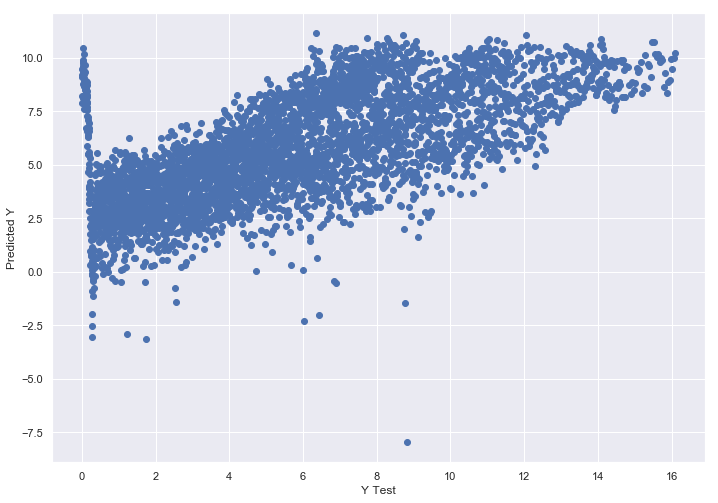

In [ ]:
plt.scatter(y_train,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [ ]:
submission = pd.read_csv('data\\sample_submission.csv', index_col='seg_id')

In [ ]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
i=0

In [ ]:
for seg_id in X_test.index:
    seg = pd.read_csv('test\\' + seg_id + '.csv')
    print("seg_id: ",seg_id)
    print("count test: ",i)
    i=i+1
    
    x = pd.Series(seg['acoustic_data'].values)
    z = np.fft.fft(x)
    #FFT transform values
    realFFT = np.real(z)
    imagFFT = np.imag(z)
    
    X_test.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X_test.loc[seg_id, 'Rstd__last_15000'] = realFFT[-15000:].std()
    X_test.loc[seg_id, 'Imean'] = imagFFT.mean()
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

    for windows in [10,100,300,600,1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    
    



seg_id:  seg_00030f
count test:  1444
seg_id:  seg_0012b5
count test:  1445
seg_id:  seg_00184e
count test:  1446
seg_id:  seg_003339
count test:  1447
seg_id:  seg_0042cc
count test:  1448
seg_id:  seg_004314
count test:  1449
seg_id:  seg_004cd2
count test:  1450
seg_id:  seg_004ee5
count test:  1451
seg_id:  seg_004f1f
count test:  1452
seg_id:  seg_00648a
count test:  1453
seg_id:  seg_006e4a
count test:  1454
seg_id:  seg_007a37
count test:  1455
seg_id:  seg_00a37e
count test:  1456
seg_id:  seg_00be11
count test:  1457
seg_id:  seg_00c35b
count test:  1458
seg_id:  seg_00cc91
count test:  1459
seg_id:  seg_00e5f7
count test:  1460
seg_id:  seg_00f3b9
count test:  1461
seg_id:  seg_010eab
count test:  1462
seg_id:  seg_0125d9
count test:  1463
seg_id:  seg_0144cb
count test:  1464
seg_id:  seg_0165c6
count test:  1465
seg_id:  seg_016913
count test:  1466
seg_id:  seg_016cdb
count test:  1467
seg_id:  seg_017314
count test:  1468
seg_id:  seg_01a8dc
count test:  1469
seg_id:  seg

count test:  1659
seg_id:  seg_162fc4
count test:  1660
seg_id:  seg_16566c
count test:  1661
seg_id:  seg_166f70
count test:  1662
seg_id:  seg_168d1c
count test:  1663
seg_id:  seg_16a270
count test:  1664
seg_id:  seg_16c3a7
count test:  1665
seg_id:  seg_17067e
count test:  1666
seg_id:  seg_170684
count test:  1667
seg_id:  seg_170a0c
count test:  1668
seg_id:  seg_176542
count test:  1669
seg_id:  seg_17799c
count test:  1670
seg_id:  seg_179d90
count test:  1671
seg_id:  seg_17adc0
count test:  1672
seg_id:  seg_17d1ff
count test:  1673
seg_id:  seg_17e596
count test:  1674
seg_id:  seg_180481
count test:  1675
seg_id:  seg_18096a
count test:  1676
seg_id:  seg_1815fe
count test:  1677
seg_id:  seg_1827c5
count test:  1678
seg_id:  seg_184222
count test:  1679
seg_id:  seg_185ad6
count test:  1680
seg_id:  seg_18d1d0
count test:  1681
seg_id:  seg_18d307
count test:  1682
seg_id:  seg_18f633
count test:  1683
seg_id:  seg_18f853
count test:  1684
seg_id:  seg_18fb65
count test: 

seg_id:  seg_2c3203
count test:  1875
seg_id:  seg_2c5e9f
count test:  1876
seg_id:  seg_2c6011
count test:  1877
seg_id:  seg_2c69e4
count test:  1878
seg_id:  seg_2c762c
count test:  1879
seg_id:  seg_2cac57
count test:  1880
seg_id:  seg_2cadc0
count test:  1881
seg_id:  seg_2cdbe3
count test:  1882
seg_id:  seg_2d3828
count test:  1883
seg_id:  seg_2d402d
count test:  1884
seg_id:  seg_2d427f
count test:  1885
seg_id:  seg_2d5544
count test:  1886
seg_id:  seg_2d7cc4
count test:  1887
seg_id:  seg_2d92f0
count test:  1888
seg_id:  seg_2db7dc
count test:  1889
seg_id:  seg_2dc6ff
count test:  1890
seg_id:  seg_2dccec
count test:  1891
seg_id:  seg_2dcd3a
count test:  1892
seg_id:  seg_2dcd84
count test:  1893
seg_id:  seg_2dfb91
count test:  1894
seg_id:  seg_2e2372
count test:  1895
seg_id:  seg_2e50fb
count test:  1896
seg_id:  seg_2e64af
count test:  1897
seg_id:  seg_2e71dd
count test:  1898
seg_id:  seg_2e88dd
count test:  1899
seg_id:  seg_2e917f
count test:  1900
seg_id:  seg

count test:  2090
seg_id:  seg_41f45e
count test:  2091
seg_id:  seg_420bcc
count test:  2092
seg_id:  seg_420d4e
count test:  2093
seg_id:  seg_421a96
count test:  2094
seg_id:  seg_421da1
count test:  2095
seg_id:  seg_423ebe
count test:  2096
seg_id:  seg_425462
count test:  2097
seg_id:  seg_42648c
count test:  2098
seg_id:  seg_4280d9
count test:  2099
seg_id:  seg_428d66
count test:  2100
seg_id:  seg_42c4c9
count test:  2101
seg_id:  seg_42e7e8
count test:  2102
seg_id:  seg_42ff14
count test:  2103
seg_id:  seg_430e66
count test:  2104
seg_id:  seg_43383f
count test:  2105
seg_id:  seg_434c96
count test:  2106
seg_id:  seg_43597f
count test:  2107
seg_id:  seg_43c6f4
count test:  2108
seg_id:  seg_440106
count test:  2109
seg_id:  seg_4401d8
count test:  2110
seg_id:  seg_441c6d
count test:  2111
seg_id:  seg_4435bd
count test:  2112
seg_id:  seg_447972
count test:  2113
seg_id:  seg_447b8b
count test:  2114
seg_id:  seg_447cb3
count test:  2115
seg_id:  seg_44d3ca
count test: 

seg_id:  seg_578e84
count test:  2306
seg_id:  seg_57908c
count test:  2307
seg_id:  seg_57b6c0
count test:  2308
seg_id:  seg_57dd68
count test:  2309
seg_id:  seg_57ea44
count test:  2310
seg_id:  seg_580b65
count test:  2311
seg_id:  seg_581fac
count test:  2312
seg_id:  seg_585872
count test:  2313
seg_id:  seg_586726
count test:  2314
seg_id:  seg_586c0f
count test:  2315
seg_id:  seg_5887a8
count test:  2316
seg_id:  seg_588f61
count test:  2317
seg_id:  seg_58d52d
count test:  2318
seg_id:  seg_58e74b
count test:  2319
seg_id:  seg_58e9f9
count test:  2320
seg_id:  seg_58ea74
count test:  2321
seg_id:  seg_59058a
count test:  2322
seg_id:  seg_590fa5
count test:  2323
seg_id:  seg_591954
count test:  2324
seg_id:  seg_5924f5
count test:  2325
seg_id:  seg_592807
count test:  2326
seg_id:  seg_593c34
count test:  2327
seg_id:  seg_5965d8
count test:  2328
seg_id:  seg_596ae3
count test:  2329
seg_id:  seg_5975f4
count test:  2330
seg_id:  seg_597bd6
count test:  2331
seg_id:  seg

count test:  2521
seg_id:  seg_6eedcc
count test:  2522
seg_id:  seg_6f17de
count test:  2523
seg_id:  seg_6f2222
count test:  2524
seg_id:  seg_6f3d90
count test:  2525
seg_id:  seg_6f60b2
count test:  2526
seg_id:  seg_6f650f
count test:  2527
seg_id:  seg_6f9a98
count test:  2528
seg_id:  seg_6fb17f
count test:  2529
seg_id:  seg_6fc3ef
count test:  2530
seg_id:  seg_6fc8b3
count test:  2531
seg_id:  seg_6fd5bb
count test:  2532
seg_id:  seg_7012af
count test:  2533
seg_id:  seg_7020c5
count test:  2534
seg_id:  seg_702e03
count test:  2535
seg_id:  seg_703cea
count test:  2536
seg_id:  seg_705463
count test:  2537
seg_id:  seg_708349
count test:  2538
seg_id:  seg_70991d
count test:  2539
seg_id:  seg_709b6a
count test:  2540
seg_id:  seg_709d08
count test:  2541
seg_id:  seg_70a60e
count test:  2542
seg_id:  seg_70b375
count test:  2543
seg_id:  seg_70be4d
count test:  2544
seg_id:  seg_70e891
count test:  2545
seg_id:  seg_70edf5
count test:  2546
seg_id:  seg_70fb30
count test: 

seg_id:  seg_82c138
count test:  2737
seg_id:  seg_82ce27
count test:  2738
seg_id:  seg_82d7b6
count test:  2739
seg_id:  seg_830cff
count test:  2740
seg_id:  seg_8310ea
count test:  2741
seg_id:  seg_8324a4
count test:  2742
seg_id:  seg_8328f5
count test:  2743
seg_id:  seg_832a4d
count test:  2744
seg_id:  seg_8344ee
count test:  2745
seg_id:  seg_8353f5
count test:  2746
seg_id:  seg_836aac
count test:  2747
seg_id:  seg_836ef0
count test:  2748
seg_id:  seg_83bef8
count test:  2749
seg_id:  seg_83cb2c
count test:  2750
seg_id:  seg_83dc2e
count test:  2751
seg_id:  seg_83ef67
count test:  2752
seg_id:  seg_83f476
count test:  2753
seg_id:  seg_83f89e
count test:  2754
seg_id:  seg_83f928
count test:  2755
seg_id:  seg_8456d3
count test:  2756
seg_id:  seg_845a2a
count test:  2757
seg_id:  seg_8472f3
count test:  2758
seg_id:  seg_848695
count test:  2759
seg_id:  seg_84a65d
count test:  2760
seg_id:  seg_84b9d9
count test:  2761
seg_id:  seg_84c7fb
count test:  2762
seg_id:  seg

count test:  2952
seg_id:  seg_97ad82
count test:  2953
seg_id:  seg_97d9ed
count test:  2954
seg_id:  seg_97e4a9
count test:  2955
seg_id:  seg_9802c3
count test:  2956
seg_id:  seg_9825e0
count test:  2957
seg_id:  seg_983778
count test:  2958
seg_id:  seg_986976
count test:  2959
seg_id:  seg_986b6e
count test:  2960
seg_id:  seg_9872f9
count test:  2961
seg_id:  seg_988e69
count test:  2962
seg_id:  seg_98a819
count test:  2963
seg_id:  seg_98be13
count test:  2964
seg_id:  seg_98c0b6
count test:  2965
seg_id:  seg_98c44d
count test:  2966
seg_id:  seg_98c544
count test:  2967
seg_id:  seg_98ebaa
count test:  2968
seg_id:  seg_98f624
count test:  2969
seg_id:  seg_9940e8
count test:  2970
seg_id:  seg_996c37
count test:  2971
seg_id:  seg_99ccbd
count test:  2972
seg_id:  seg_99f677
count test:  2973
seg_id:  seg_99f76c
count test:  2974
seg_id:  seg_9a1a4f
count test:  2975
seg_id:  seg_9a1c76
count test:  2976
seg_id:  seg_9a43ef
count test:  2977
seg_id:  seg_9a6025
count test: 

In [ ]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = lm.predict(X_test_scaled)
submission.to_csv('submission.csv')